<a href="https://colab.research.google.com/github/ibonetc/IA_2024/blob/main/Heur%C3%ADstica_AlgoritmosB%C3%BAsqueda/IA_EIA_LatLong_InformacionMapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización en mapas

Captura de información para poder hacer métodos de rutas

Se debe instalar el paquete osmnx, que permite obtener mapas en un grafo con información de latitud y longitud de diferentes puntos, con sus distancias

**Nota** : Después de instalar la biblioteca osmnx debe reiniciar el entorno de ejecuación y entonces ejecutar el siguiente código

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
#ox.config(use_cache=True, log_console=True)

## Mapa de Envigado

La función **graph_from_place** recibe un texto con la dirección del lugar que se desea buscar, y tiene un parámetro *network_type* para ver cómo se desea obtener el mapa, en nuestro caso que queremos hacer ruts para trayecto en carro escogeremos: 'drive'

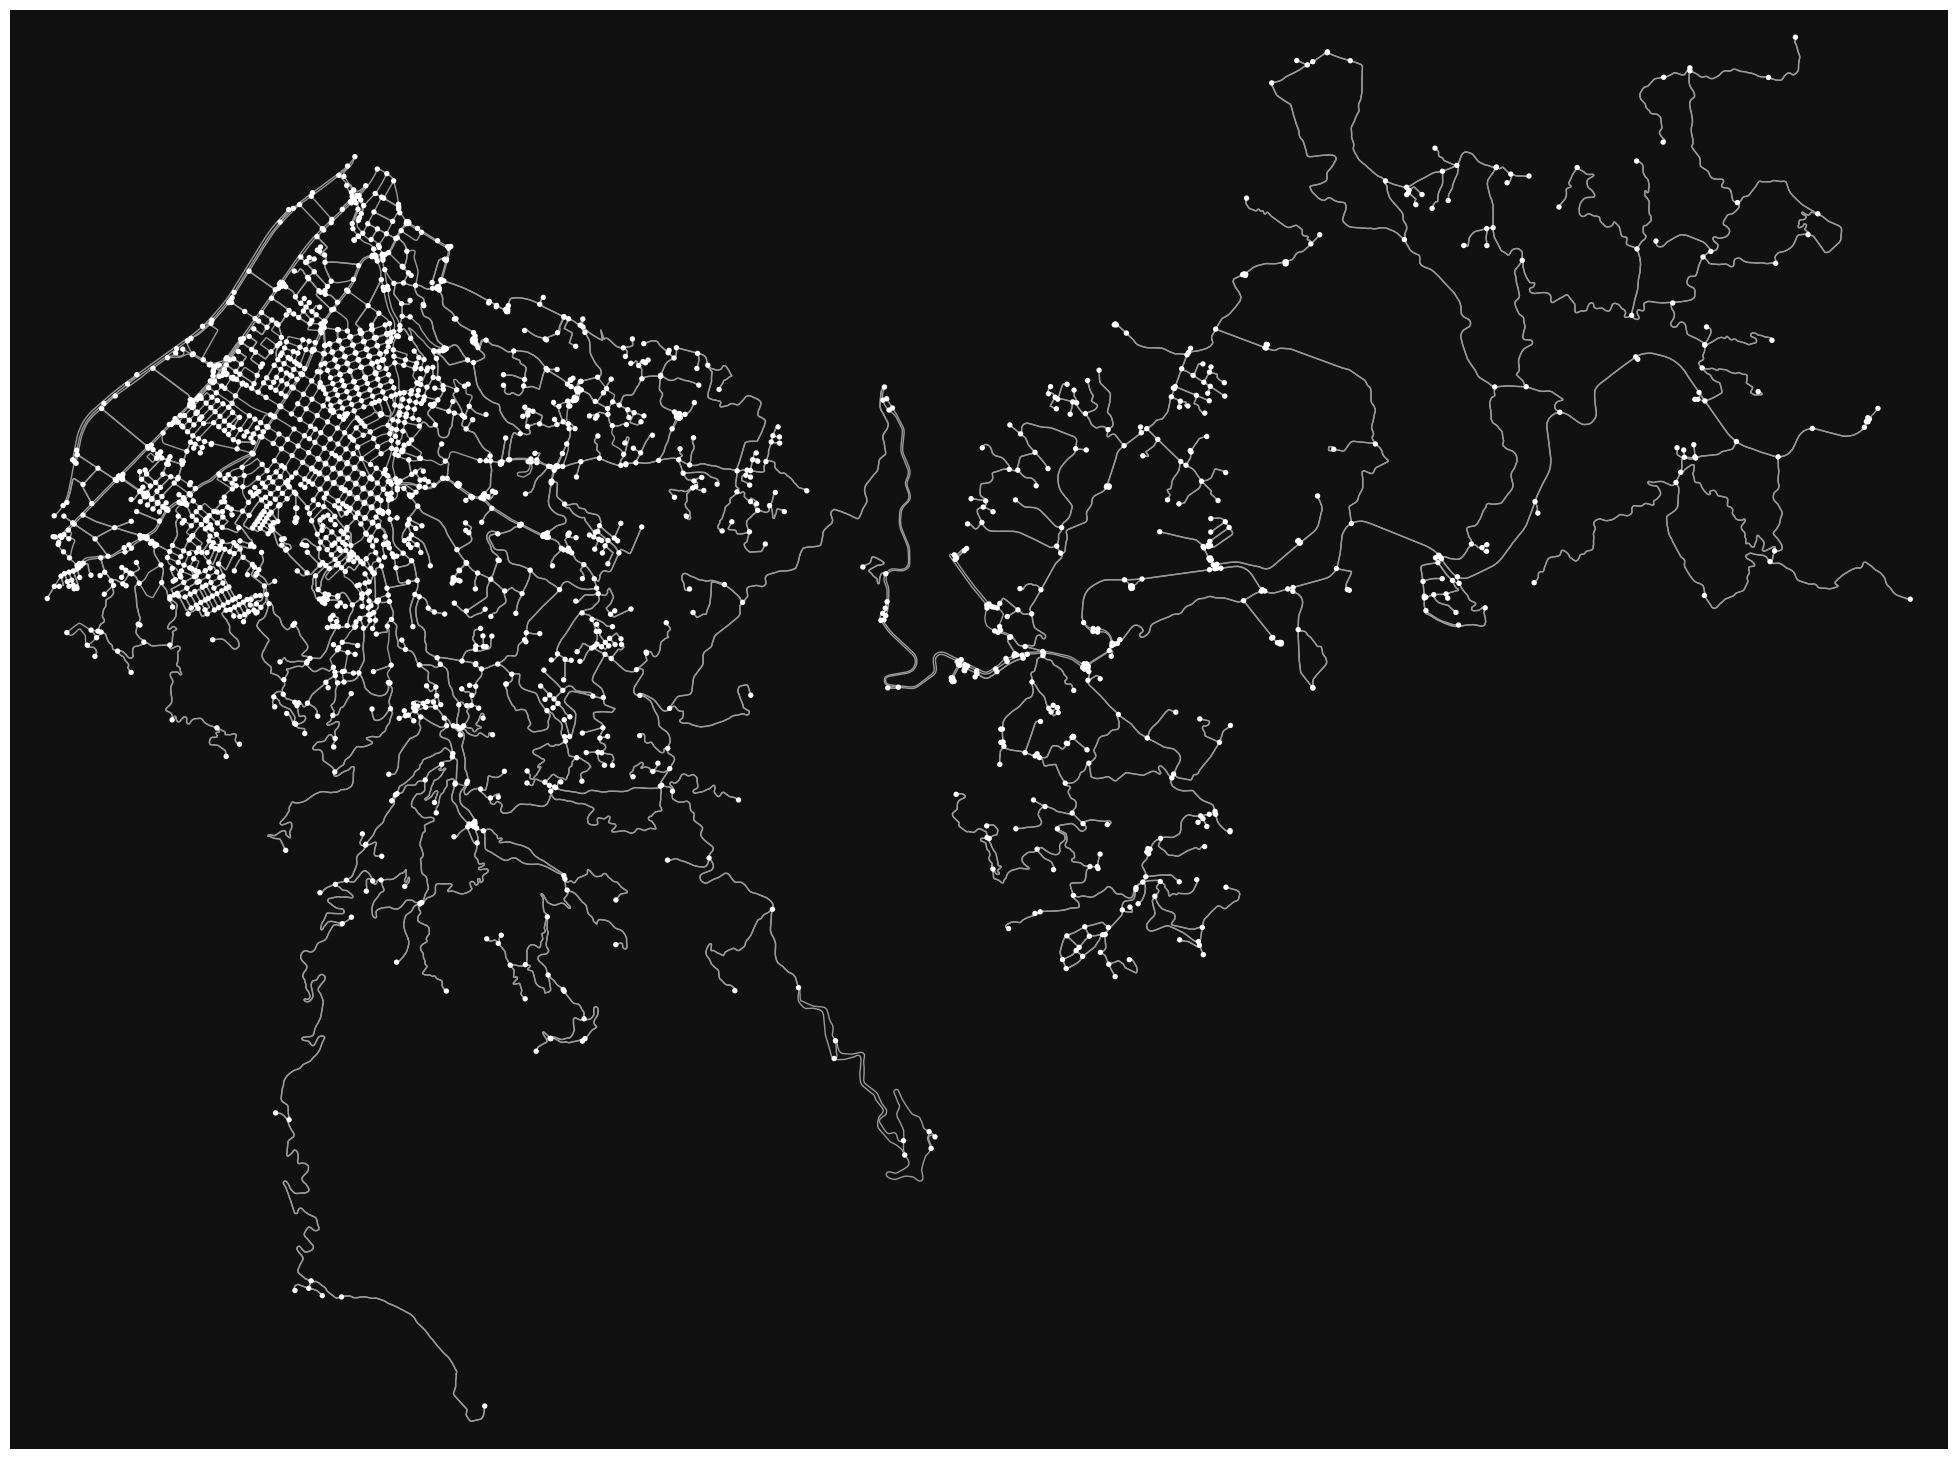

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [3]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive')
ox.plot_graph(G,figsize=(25,25))

La función por defecto tiene un parámetro *simplify* puesto en True, por lo que trae un grafo simplificado, con pocos puntos. Como queremos tratar de mostrar el trayecto completo de la ruta vamos a traer más información del mapa y pondremos el parámetro en False.

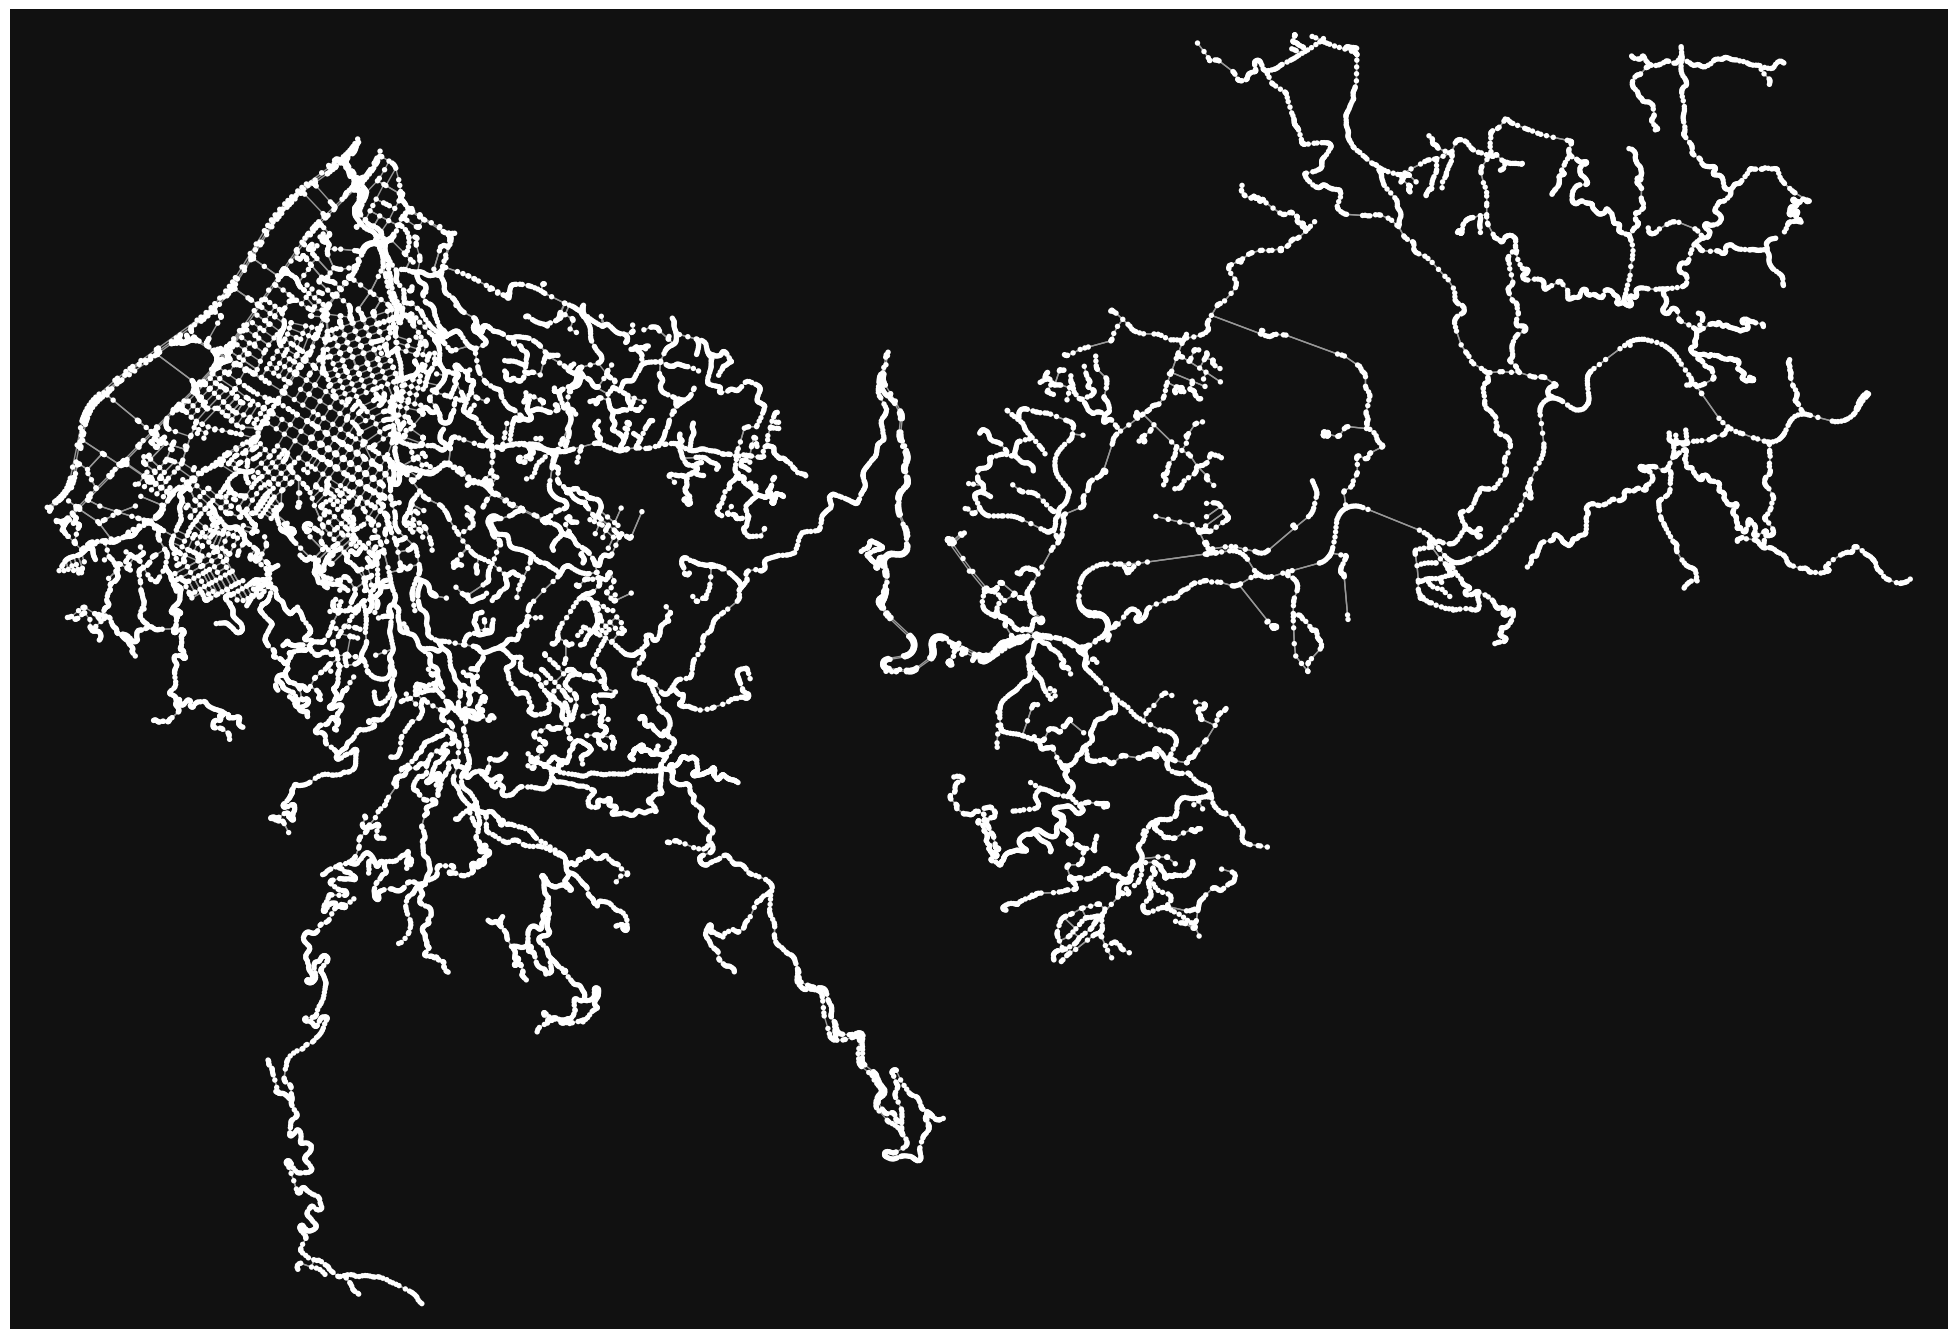

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [4]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=False)
ox.plot_graph(G,figsize=(25,25))

La función *graph_to_gdfs(G)* nos devuelve dos dataframe uno con los nodos y otro con las aristas del grafo.

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
gdf_nodes.head()

y          x  street_count highway  \
osmid                                                  
309313450  6.158425 -75.519823             2     NaN   
309313451  6.158399 -75.520285             2     NaN   
309313454  6.159630 -75.521495             2     NaN   
309313455  6.160208 -75.522473             2     NaN   
309313457  6.159980 -75.524411             3     NaN   

                            geometry  
osmid                                 
309313450  POINT (-75.51982 6.15843)  
309313451  POINT (-75.52028 6.15840)  
309313454  POINT (-75.52150 6.15963)  
309313455  POINT (-75.52247 6.16021)  
309313457  POINT (-75.52441 6.15998)

In [7]:
gdf_edges.head()

osmid lanes                 name    highway  \
u         v          key                                                     
309313450 414940715  0    1019189334     2  Variante Las Palmas  secondary   
          440765240  0    1019189334     2  Variante Las Palmas  secondary   
309313451 414940727  0    1019189334     2  Variante Las Palmas  secondary   
          414940715  0    1019189334     2  Variante Las Palmas  secondary   
309313454 4124260034 0    1019190824     2  Variante Las Palmas  secondary   

                         maxspeed  oneway  reversed  length  ref width  \
u         v          key                                                 
309313450 414940715  0         50   False     False  24.138  NaN   NaN   
          440765240  0         50   False      True  91.294  NaN   NaN   
309313451 414940727  0         50   False     False  26.538  NaN   NaN   
          414940715  0         50   False      True  27.314  NaN   NaN   
309313454 4124260034 0         60   False     False  25.382  NaN   NaN   

                         junction bridge access  \
u         v          key                          
309313450 414940715  0        NaN    NaN    NaN   
          440765240  0        NaN    NaN    NaN   
309313451 414940727  0        NaN    NaN    NaN   
          414940715  0        NaN    NaN    NaN   
309313454 4124260034 0        NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309313450 414940715  0    LINESTRING (-75.51982 6.15843, -75.52004 6.15839)  
          440765240  0    LINESTRING (-75.51982 6.15843, -75.51903 6.15866)  
309313451 414940727  0    LINESTRING (-75.52028 6.15840, -75.52051 6.15847)  
          414940715  0    LINESTRING (-75.52028 6.15840, -75.52004 6.15839)  
309313454 4124260034 0    LINESTRING (-75.52150 6.15963, -75.52164 6.15981)

In [8]:
gdf_edges.loc[309313450].index.get_level_values('v').unique()

Index([414940715, 440765240], dtype='int64', name='v')

In [14]:
from ai import Node

class Intersection(Node):

  def getchildrens(self):
    return [
        state
          if not self.repeatStatePath(state)
            else None for state in gdf_edges.loc[self.state].index.get_level_values('v').unique()]

  def cost(self):
    if self.parent is None:
      return 0
    slef_cost = 1
    return slef_cost + self.parent.cost()

  def heuristic(self):
    if self.state == "endState":
      return 0
    else:
      return 1

In [ ]:
MapaTree = Tree(Mapa(state=initState, operators= [
    state for state, c in adjacents(initState)], objective=endState))
objective = MapaTree.aAsterisk(endState=endState)
MapaTree.draw()

Si observamos una parte del dataframe de las aristas, podemos ver que tenemos toda la información donde *u* es el nodo de partida, *v* el nodo de destino en cada uno de las conecciones de los puntos, tenemos el nombre del lugar o calle (name), el tipo de carretera (highway), la máxima velocidad en ese lugar (maxspeed), pero esta variable tiene varios nulos, para poder calcular tiempo en recurrido necesitamos llenar estos campos vacíos.

Podemos crear una variable speed_kph que se completa con los valores maxspeed y rellena los vacíos, por defecto, la función add_edge_speeds(G) rellena los vacíos con el promedio de ese tipo de carretera, en el mapa, pero podemos también pasarle unos valores fijos, como se hizo anteriormente.

Adicionar una columna con velocidad (**speed_kph**), a partir de la maxspeed que hay

Adicionar otra columna con el tiempo de viaje (**travel_time**)

In [9]:
#G = ox.add_edge_speeds(G)
# Para que en vez del promedio del tipo de vía, ponga uno específico como esté null
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [10]:
gdf_edges[150:200]

osmid lanes          name       highway  \
u         v           key                                                 
330634666 1378816147  0     297281673   NaN    Carrera 39   residential   
          330634181   0     577258425     3  Calle 37 Sur     secondary   
330634667 8895905676  0     123728026     2    Carrera 38   residential   
          330634666   0     577258425     3  Calle 37 Sur     secondary   
          3924033402  0    1018623735     2    Carrera 38   residential   
330634668 330634667   0     577258425     3  Calle 37 Sur     secondary   
          1378816149  0    1018848145     1    Carrera 37   residential   
330634669 5534334357  0     351458389     3  Calle 37 Sur     secondary   
          10174239725 0    1018623736     2    Carrera 36   residential   
330634981 10699845192 0     351458388     2  Calle 37 Sur     secondary   
330634987 10774142105 0     389248617     1   Carrera 29B      tertiary   
          5529679663  0     576533571     2   Diagonal 31     secondary   
330634988 10174239750 0     577255132     3  Calle 38 Sur     secondary   
          10174239752 0    1018848587     2    Carrera 31   residential   
330634990 3924033388  0     577255133     2  Calle 38 Sur     secondary   
          9397383703  0    1018851100     2    Carrera 33   residential   
330634991 9397383706  0     576533589     1  Calle 38 Sur     secondary   
          10724477198 0    1018851099     1    Carrera 34   residential   
330634992 10174239735 0     576533588     1  Calle 38 Sur     secondary   
          10174239737 0    1018848140     2    Carrera 35   residential   
330634993 10174239723 0     576533588     1  Calle 38 Sur     secondary   
          5529679696  0    1018848147     2    Carrera 36   residential   
330634994 8895905677  0    1018848145     1    Carrera 37   residential   
          10174239712 0    1018848148     1  Calle 38 Sur     secondary   
330634995 10724514155 0     123728026     2    Carrera 38   residential   
          10724477202 0     906423565     3  Calle 38 Sur     secondary   
330634997 8895905674  0     297281673   NaN    Carrera 39   residential   
          10724514108 0     576533591     3  Calle 38 Sur     secondary   
330634999 8895905678  0     154884791   NaN    Carrera 41   residential   
          10724514128 0     577255130     3  Calle 38 Sur     secondary   
330635000 10724514134 0     577255130     3  Calle 38 Sur     secondary   
          10724514160 0    1019184059     1    Carrera 42   residential   
330635001 10724514140 0     576112578     3  Calle 38 Sur     secondary   
330636751 11986724602 0     935662832     1           NaN  primary_link   
330636752 6927580879  0     935662832     1           NaN  primary_link   
330636754 5496798845  0    1292978638     2  Calle 25 Sur     secondary   
330636755 11986703631 0    1292978638     2  Calle 25 Sur     secondary   
330636756 10699863702 0    1292978638     2  Calle 25 Sur     secondary   
330636757 3576471509  0     442843365     2  Calle 25 Sur     secondary   
330636759 3576471503  0     442843365     2  Calle 25 Sur     secondary   
330636760 3576471371  0     442843365     2  Calle 25 Sur     secondary   
330636765 330636766   0    1150201140     2  Calle 25 Sur     secondary   
330636766 4404924426  0    1150201140     2  Calle 25 Sur     secondary   
330636767 10699863651 0      44923416   NaN   Diagonal 32   residential   
          4404924412  0    1150201140     2  Calle 25 Sur     secondary   
330636769 4404924283  0    1150201140     2  Calle 25 Sur     secondary   
330636770 9396988942  0    1150201140     2  Calle 25 Sur     secondary   
330636771 9396988941  0    1150201140     2  Calle 25 Sur     secondary   
330636772 569680296   0    1150201140     2  Calle 25 Sur     secondary   
330636774 9397808499  0    1150201140     2  Calle 25 Sur     secondary   

                          maxspeed  oneway  reversed  length  speed_kph  \
u         v           key                               

In [ ]:
gdf_edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

length  speed_kph  travel_time
highway                                       
living_street     26.8       44.6          2.2
motorway_link     38.9       44.6          3.1
primary           27.0       50.5          2.0
primary_link       8.3       30.0          1.0
residential       21.1       34.8          2.2
secondary         23.4       48.6          1.8
secondary_link    11.4       30.0          1.4
tertiary          24.4       56.0          1.6
tertiary_link      7.7       44.6          0.6
trunk             45.2       77.7          2.1
trunk_link        11.8       44.6          0.9
unclassified      18.7       23.6          2.9

Si necesitamos buscar latitudes y longitudes de lugares específicos para buscar en un mapa podemos usar el biblioteca geopy que con Nominatim que nos permite hacerlo gratis

## Ejemplo de mostrar una ruta

In [ ]:
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')

Acá busco la longitud y latitud de la Sede de posgrados de la EIA y la sede de Palmas. Esto devuelve una variable que tiene la dirección completa y la longitud y latitud

In [ ]:
location_start = locator.geocode('Sede Posgrados EIA, Envigado, Colombia')
location_end=locator.geocode('Universidad EIA, Envigado, Colombia')

In [ ]:
print(location_start.address)
print(location_end.address)

Sede Posgrados EIA, Calle 25 Sur, La Magnolia, Envigado, Valle de Aburrá, Antioquia, Región Andina, 3549090, Colombia
Escuela de Ingeniería de Antioquia, km 2+200, Vía Acceso P. Palmitas, Envigado, Valle de Aburrá, Antioquia, Región Andina, 055420, Colombia


In [ ]:
print((location_start.latitude, location_start.longitude))
print((location_end.latitude, location_end.longitude))

(6.1789229, -75.57947803842347)
(6.15696005, -75.51685480358233)


Como un ejemplo de mostrar una ruta en el mapa vamos a usar la biblioteca nx con la función ***shortest_path*** que recibe un grafo de mapa, un punto de origen y uno de destino y según un peso, en este caso tiempo (por la columna *travel_time*), busca una ruta utilizando el algoritmo *dijkstra*.

Con la función ***plot_graph_route*** de ox se puede dibujar una ruta, se le debe pasar una lista de la ruta con los códigos de los nodos del grafo a dibujar en la ruta.

In [ ]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.get_nearest_node(G, start)
end_node = ox.get_nearest_node(G, end)
route1 = nx.shortest_path(G, start_node, end_node, weight='travel_time')
print(route1)

[3648102725, 340686744, 340686745, 340686746, 4404924419, 4404924420, 340686060, 4404924418, 4404924417, 3648101524, 340686059, 4404924394, 3648101523, 3648101522, 4404924400, 4404924399, 4404924397, 4404924395, 3648102740, 338172930, 3648102733, 4404924390, 338172929, 3648101520, 4404924284, 338172928, 338172927, 3572367329, 7115606670, 338172926, 340685471, 1841397085, 1841397172, 1841397053, 1841397105, 1841397060, 1841397113, 1841397024, 1841397145, 2218640191, 1841397160, 1841397062, 3572367314, 1841397088, 1841397063, 1841397076, 3572367298, 3572367297, 1841397051, 1841397166, 1841397147, 3924033541, 1841397219, 1841397091, 1841397044, 1841397150, 1841397151, 1841397176, 1841397027, 6811634117, 1841397030, 1841397035, 1841397148, 6811634116, 1841397103, 6136232307, 1841397058, 1841397083, 6136232308, 1841397123, 1841397110, 1841397118, 1841397115, 6136120669, 3572367313, 3572367312, 1841397168, 1841397144, 6136120668, 6136120670, 1841397149, 1841397081, 1841397121, 1841397056, 18

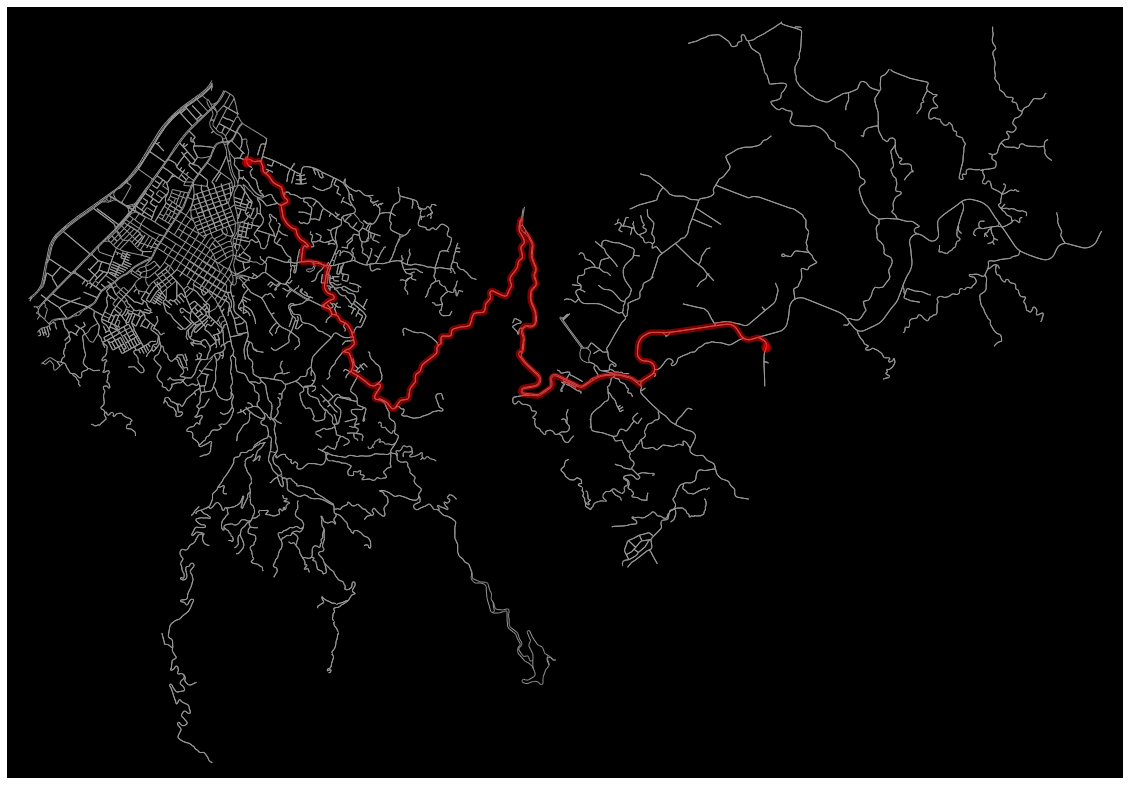

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph_route(G, route1, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

Podemos hacer el mismo ejemplo buscando otra ruta pero ahora por distancia (en este caso usaríamos como peso la columna *length*)

In [ ]:
route2 = nx.shortest_path(G, start_node, end_node, weight='length')

Comparar las dos rutas

In [ ]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Ruta 1 tiene', route1_length, 'metros y toma', route1_time, 'segundos.')
print('Ruta 2 tiene', route2_length, 'metros y toma', route2_time, 'segundos.')

Ruta 1 tiene 15910 metros y toma 1458 segundos.
Ruta 2 tiene 15081 metros y toma 1611 segundos.


In [ ]:
len(r)

2

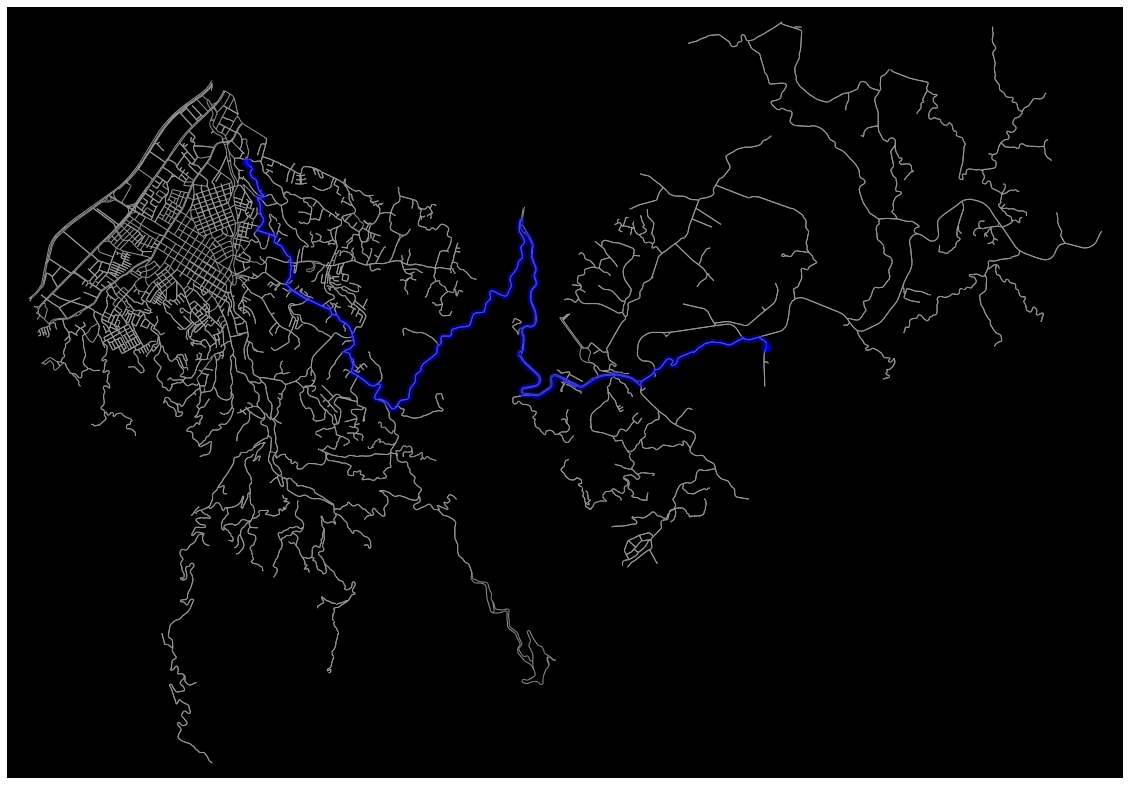

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph_route(G, route2, route_color='b',route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

## Dataframe geográfico con información del mapa

Podemos crear nuestro propio dataframe con los datos que tenemos en el grafo

In [ ]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route1[:-1], route1[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)),
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"])
df.head()

node_start    node_end     X_from  ...      Y_to  length  travel_time
0  3648102725   340686744 -75.579000  ...  6.179182      13            1
1   340686744   340686745 -75.579032  ...  6.179278      11            1
2   340686745   340686746 -75.579025  ...  6.179407      15            2
3   340686746  4404924419 -75.578987  ...  6.179438      10            1
4  4404924419  4404924420 -75.578899  ...  6.179443       6            1

[5 rows x 8 columns]

In [ ]:
df.reset_index(inplace=True)
df.head()

index  node_start    node_end  ...      Y_to  length  travel_time
0      0  3648102725   340686744  ...  6.179182      13            1
1      1   340686744   340686745  ...  6.179278      11            1
2      2   340686745   340686746  ...  6.179407      15            2
3      3   340686746  4404924419  ...  6.179438      10            1
4      4  4404924419  4404924420  ...  6.179443       6            1

[5 rows x 9 columns]

Crear un dataframe geográfico a partir de este para poder tneer las longitudes y latitudes comp puntos geométricos

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')

In [ ]:
df.tail()

index  ...                           geometry_to
783    783  ...         POINT (-75.5181102 6.1580916)
784    784  ...         POINT (-75.5180458 6.1579475)
785    785  ...  POINT (-75.51801089999999 6.1577942)
786    786  ...          POINT (-75.518019 6.1576115)
787    787  ...         POINT (-75.5180525 6.1574569)

[5 rows x 11 columns]

In [ ]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [ ]:
start

index  node_start  ...                   geometry                    geometry_to
0      0  3648102725  ...  POINT (-75.57900 6.17907)  POINT (-75.5788754 6.1788019)

[1 rows x 11 columns]

In [ ]:
end

index  ...                    geometry_to
768    768  ...  POINT (-75.5180525 6.1574569)

[1 rows x 11 columns]

## Diferentes formas de visualización en otros mapas

In [ ]:
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)

In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", width=800, height=400, zoom=12)
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])

Mapbox requiere access token para algunas visualizaciones como:

'basic', 'streets', 'outdoors', 'light', 'dark', 'satellite', 'satellite- streets'

Sin embargo hay otros mapbox_style que no requieren access token como:

'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen- terrain', 'stamen-toner', 'stamen-watercolor'

In [ ]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, animation_frame="index",mapbox_style='open-street-map')
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

In [ ]:
#graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
route_graph_map = ox.plot_route_folium(G, route,popup_attribute='name', edge_width=2)
route_graph_map.save('route.html')

In [ ]:
display(route_graph_map)